In [26]:
# Widget to manipulate plots in Jupyter notebooks
%matplotlib widget

import matplotlib.pyplot as plt # For general plotting
import matplotlib as mpl
from matplotlib.ticker import MaxNLocator

from math import ceil, floor

import numpy as np

from scipy.stats import multivariate_normal as mvn

from skimage.io import imread

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.preprocessing import LabelBinarizer
from sklearn.svm import SVC

import torch
import torch.nn as nn
import torch.nn.functional as F

# Utility to visualize PyTorch network and shapes
from torchsummary import summary

np.set_printoptions(suppress=True)

# Set seed to generate reproducible "pseudo-randomness" (handles scipy's "randomness" too)
np.random.seed(4)

plt.rc('font', size=22)          # controls default text sizes
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=18)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
plt.rc('legend', fontsize=16)    # legend fontsize
plt.rc('figure', titlesize=22)   # fontsize of the figure title



1212


In [12]:
def plot_binary_classification_results(ax, predictions, labels):
    # Get indices of the four decision scenarios:
    # True Negatives
    tn = np.argwhere((predictions == -1) & (y_test == -1))
    # False Positives
    fp = np.argwhere((predictions == 1) & (y_test == -1))
    # False Negative Probability
    fn = np.argwhere((predictions == -1) & (y_test == 1))
    # True Positive Probability
    tp = np.argwhere((predictions == 1) & (y_test == 1))

    # class -1 circle, class 1 +, correct green, incorrect red
    ax.plot(X_test[tn, 0], X_test[tn, 1], 'og', label="Correct Class -1");
    ax.plot(X_test[fp, 0], X_test[fp, 1], 'or', label="Incorrect Class -1");
    ax.plot(X_test[fn, 0], X_test[fn, 1], '+r', label="Incorrect Class 1");
    ax.plot(X_test[tp, 0], X_test[tp, 1], '+g', label="Correct Class 1");

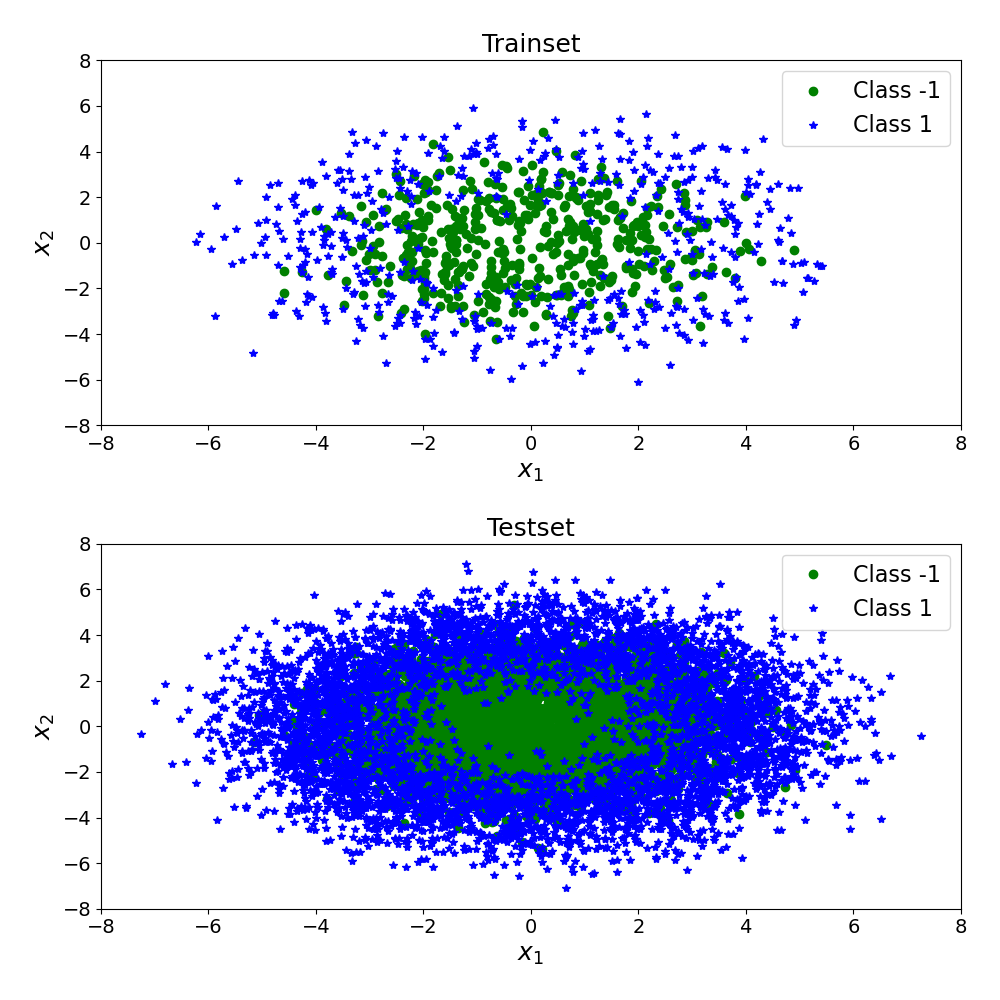

In [28]:
def generate_multiring_dataset(N, n, pdf_params):
    # Output samples and labels
    X = np.zeros([N, n])
    # Note that the labels are either -1 or +1, binary classification
    labels = np.ones(N)

    # Decide randomly which samples will come from each class
    indices = np.random.rand(N) < pdf_params['prior']
    # Reassign random samples to the negative class values (to -1)
    labels[indices] = -1
    num_neg = sum(indices)

    # Create mixture distribution
    theta = np.random.uniform(low=-np.pi, high=np.pi, size=N)
    uniform_component = np.array([np.cos(theta), np.sin(theta)]).T

    # Positive class samples
    X[~indices] = pdf_params['r+'] * uniform_component[~indices] + mvn.rvs(pdf_params['mu'], pdf_params['Sigma'],
                                                                           N-num_neg)
    # Negative class samples
    X[indices] = pdf_params['r-'] * uniform_component[indices] + mvn.rvs(pdf_params['mu'], pdf_params['Sigma'],
                                                                         num_neg)
    return X, labels

# Two-dimensional data
n = 2
# Mixture distribution of a uniform and Gaussian RV for a two-class problem
mix_pdf = {}
mix_pdf['r+'] = 4
mix_pdf['r-'] = 2
mix_pdf['prior'] = 0.5
mix_pdf['mu'] = np.zeros(n)
mix_pdf['Sigma'] = np.identity(n)

# Number of training and test set samples
N_train = 1000
N_test = 10000

# Generate training and test sets
X_train, y_train = generate_multiring_dataset(N_train, n, mix_pdf)
X_test, y_test = generate_multiring_dataset(N_test, n, mix_pdf)

# Plot the original data and their true labels
fig, ax = plt.subplots(2, 1, figsize=(10, 10))

ax[0].set_title("Trainset")
ax[0].plot(X_train[y_train==-1, 0], X_train[y_train==-1, 1],'go', label="Class -1")
ax[0].plot(X_train[y_train==1, 0], X_train[y_train==1, 1], 'b*', label="Class 1")
ax[0].set_xlabel(r"$x_1$")
ax[0].set_ylabel(r"$x_2$")
ax[0].legend()

ax[1].set_title("Testset")
ax[1].plot(X_test[y_test==-1, 0], X_test[y_test==-1, 1], 'go', label="Class -1")
ax[1].plot(X_test[y_test==1, 0], X_test[y_test==1, 1], 'b*', label="Class 1")
ax[1].set_xlabel(r"$x_1$")
ax[1].set_ylabel(r"$x_2$")
ax[1].legend()

# Using test set samples to limit axes
x1_lim = (floor(np.min(X_test[:,0])), ceil(np.max(X_test[:,0])))
x2_lim = (floor(np.min(X_test[:,1])), ceil(np.max(X_test[:,1])))
# Keep axis-equal so there is new skewed perspective due to a greater range along one axis
plt.setp(ax, xlim=x1_lim, ylim=x2_lim)
plt.tight_layout()
plt.show()

Best Regularization Strength: 0.100
Best Kernel Width: 0.100
SVM CV Pr(error): 0.179


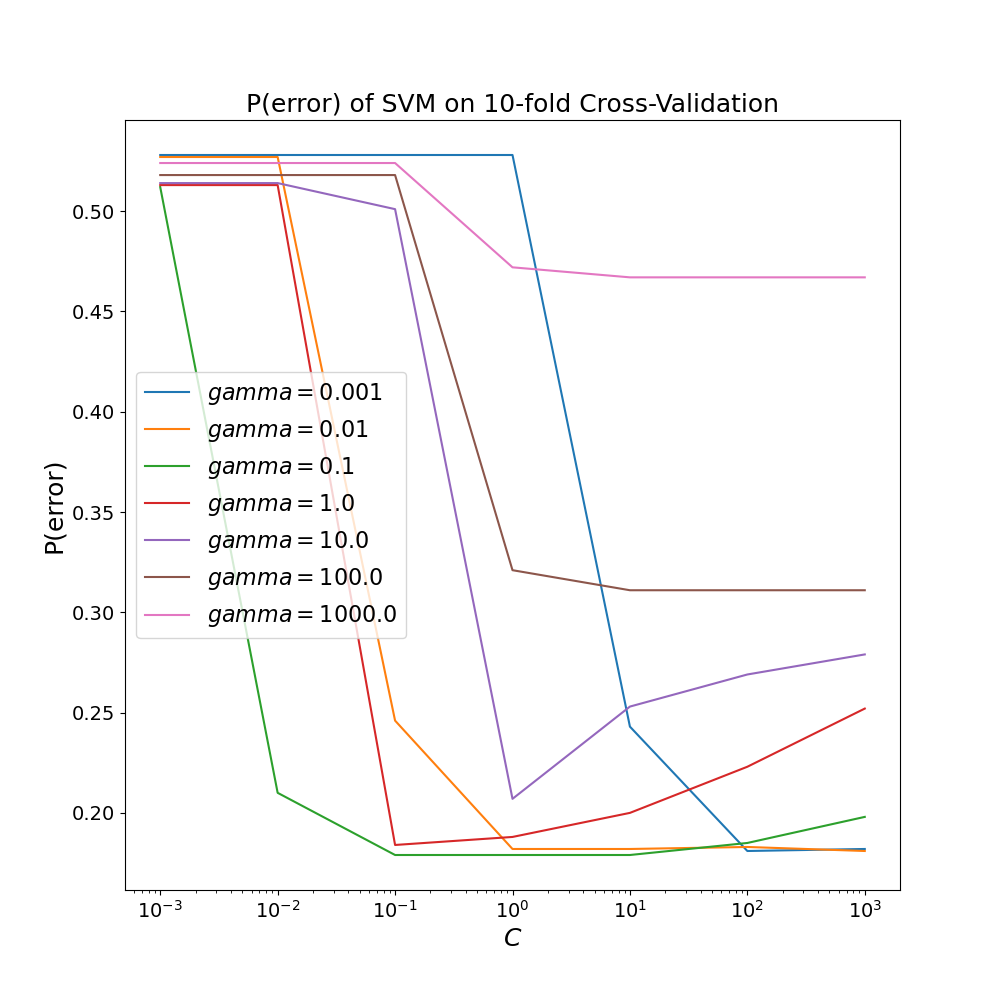

In [29]:
# 10-fold CV
K = 10

# Set up parameters to evaluate using GridSearchCV
C_range = np.logspace(-3, 3, 7)
gamma_range = np.logspace(-3, 3, 7)
param_grid = {'C': C_range, 'gamma': gamma_range}

# Specifying that we'll use the Gaussian kernel
svc = SVC(kernel='rbf')
cv = KFold(n_splits=K, shuffle=True)
classifier = GridSearchCV(estimator=svc, param_grid=param_grid, cv=cv)
classifier.fit(X_train, y_train)

C_best = classifier.best_params_['C']
gamma_best = classifier.best_params_['gamma']
print("Best Regularization Strength: %.3f" % C_best)
print("Best Kernel Width: %.3f" % gamma_best)
print("SVM CV Pr(error): %.3f" % (1-classifier.best_score_))

# Plot Pr(error) vs regularization parameter when gamma is held constant
C_data = classifier.cv_results_['param_C'].data
gamma_data = classifier.cv_results_['param_gamma'].data
cv_prob_error = 1 - classifier.cv_results_['mean_test_score']
plt.figure(figsize=(10, 10))
# Iterate over each gamma in the parameter grid
for g in gamma_range:
    # Find what C values correspond to a specific gamma
    C = C_data[gamma_data == g]
    # Sort in ascending order
    sort_idx = C.argsort()[::-1]
    # Pick out the error associated with that gamma and C combo
    prob_error = cv_prob_error[gamma_data == g]
    plt.plot(C[sort_idx], prob_error[sort_idx], label=fr"$gamma = {g}$")

plt.title("P(error) of SVM on 10-fold Cross-Validation")
plt.xscale('log')
plt.xlabel(r"$C$")
plt.ylabel("P(error)")
plt.legend()
plt.show()

SVM Pr(error) on the test data set: 0.1665



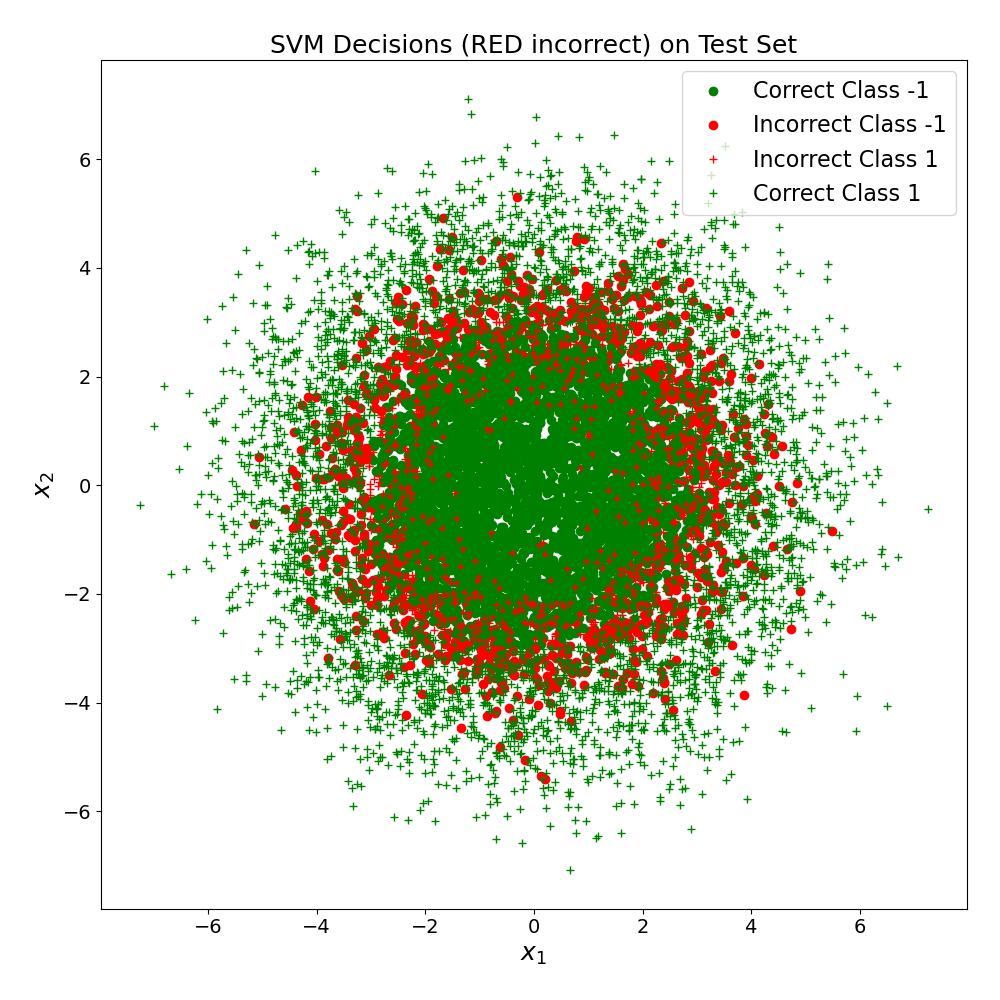

In [30]:
# Train SVM using best parameters on entire training data set
classifier = SVC(C=C_best, kernel='rbf', gamma=gamma_best)
classifier.fit(X_train, y_train)
predictions = classifier.predict(X_test)

# Get indices of correct and incorrect labels
incorrect_ind = np.argwhere(y_test != predictions)
prob_error_test = len(incorrect_ind) / N_test
print("SVM Pr(error) on the test data set: %.4f\n" % prob_error_test)

fig, ax = plt.subplots(figsize=(10, 10));

plot_binary_classification_results(ax, predictions, y_test)

# Define region of interest by data limits
x_min, x_max = X_test[:, 0].min() - 1, X_test[:, 0].max() + 1
y_min, y_max = X_test[:, 1].min() - 1, X_test[:, 1].max() + 1
x_span = np.linspace(x_min, x_max, num=200)
y_span = np.linspace(y_min, y_max, num=200)
xx, yy = np.meshgrid(x_span, y_span)

grid = np.c_[xx.ravel(), yy.ravel()]

# Z matrix are the SVM classifier predictions
Z = classifier.predict(grid).reshape(xx.shape)
#ax.contourf(xx, yy, Z, cmap=plt.cm.viridis, alpha=0.25)

ax.set_xlabel(r"$x_1$");
ax.set_ylabel(r"$x_2$");
ax.set_title("SVM Decisions (RED incorrect) on Test Set")
plt.legend();
plt.tight_layout();
plt.show()

Confusion Matrix (rows: Predicted class, columns: True class):


Text(0.5, 0, 'Labels')

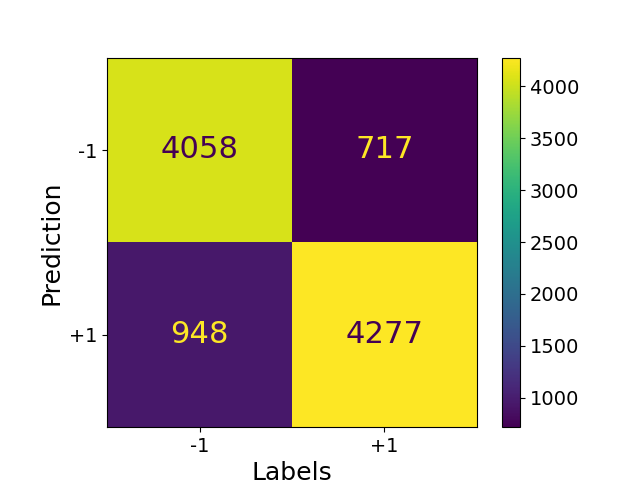

In [33]:
# Simply using sklearn confusion matrix
print("Confusion Matrix (rows: Predicted class, columns: True class):")
conf_mat = confusion_matrix(predictions, y_test)
conf_display = ConfusionMatrixDisplay.from_predictions(predictions, y_test, display_labels=['-1', '+1'], colorbar=True)
plt.ylabel("Prediction")
plt.xlabel("Labels")

In [ ]:
################ MLP ###################

In [34]:
class TwoLayerMLP(nn.Module):
    # Two-layer neural network class

    def __init__(self, in_dim, P, out_dim=1):
        super(TwoLayerMLP, self).__init__()
        # Fully connected layer WX + b mapping from n -> P
        self.input_fc = nn.Linear(in_dim, P)
        # Output layer again fully connected mapping from P -> out_dim (single output feature)
        self.output_fc = nn.Linear(P, out_dim)

    def forward(self, X):
        # X = [batch_size, input_dim]
        X = self.input_fc(X)
        # ReLU
        X = F.relu(X)
        # X = [batch_size, P]
        return self.output_fc(X)


# NOTE that I'm using BCEWithLogitsLoss as we're dealing with a two-class problem
# Can also use CrossEntropyLoss as I did before, but for output probabilities the sigmoid is more meaningful
def model_train(model, data, labels, optimizer, criterion=nn.BCEWithLogitsLoss(), num_epochs=100):
    # Set this "flag" before training
    model.train()
    # Optimize the model, e.g. a neural network
    for epoch in range(num_epochs):
        # These outputs represent the model's predicted probabilities for each class.
        outputs = model(data)
        # Criterion computes the cross entropy loss between input and target
        loss = criterion(outputs, labels.unsqueeze(1))
        # Set gradient buffers to zero explicitly before backprop
        optimizer.zero_grad()
        # Backward pass to compute the gradients through the network
        loss.backward()
        # GD step update
        optimizer.step()

    return model, loss

def model_predict(model, data):
    # Similar idea to model.train(), set a flag to let network know your in "inference" mode
    model.eval()
    # Disabling gradient calculation is useful for inference, only forward pass!!
    with torch.no_grad():
        # Evaluate nn on test data and compare to true labels
        predicted_logits = model(data)
        # Take sigmoid of pre-activations (logits) for output probabilities
        predicted_probs = torch.sigmoid(predicted_logits).detach().numpy()
        # Reshape to squeeze out last unwanted dimension
        return predicted_probs.reshape(-1)

In [43]:
def k_fold_cv_perceptrons(K, P_list, data, labels):
    # STEP 1: Partition the dataset into K approximately-equal-sized partitions
    kf = KFold(n_splits=K, shuffle=True)

    # Allocate space for CV
    error_valid_mk = np.zeros((len(P_list), K))

    # STEP 2: Iterate over all model options based on number of perceptrons
    # Track model index
    m = 0
    for P in P_list:
        # K-fold cross validation
        k = 0
        for train_indices, valid_indices in kf.split(data):
            # Extract the training and validation sets from the K-fold split
            # Convert numpy structures to PyTorch tensors, necessary data types
            X_train_k = torch.FloatTensor(data[train_indices])
            y_train_k = torch.FloatTensor(labels[train_indices])

            model = TwoLayerMLP(X_train_k.shape[1], P)

            # Stochastic GD with learning rate and momentum hyperparameters
            optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

            # Trained model
            model, _ = model_train(model, X_train_k, y_train_k, optimizer)

            X_valid_k = torch.FloatTensor(data[valid_indices])
            y_valid_k = labels[valid_indices]

            # Evaluate the neural network on the validation fold
            prediction_probs = model_predict(model, X_valid_k)
            # Decision boundary set to 0.5, hence rounding up sigmoid outputs
            predictions = np.round(prediction_probs)

            # Retain the probability of error estimates
            error_valid_mk[m, k] = np.sum(predictions != y_valid_k) / len(y_valid_k)
            k += 1
        m += 1
    # STEP 3: Compute the average prob. error (across K folds) for that model
    error_valid_m = np.mean(error_valid_mk, axis=1)

    # Return the optimal choice of P* and prepare to train selected model on entire dataset
    optimal_P = P_list[np.argmin(error_valid_m)]

    print("Best # of Perceptrons: %d" % optimal_P)
    print("Pr(error): %.3f" % np.min(error_valid_m))

    fig = plt.figure(figsize=(10, 10))
    plt.scatter(P_list, error_valid_m)
    plt.title("Number of Perceptrons vs Cross-Validation P(error)")
    plt.xlabel(r"number of perceptron")
    plt.ylabel("error rate of MLP model")
    plt.show()

    return optimal_P

Best # of Perceptrons: 96
Pr(error): 0.179


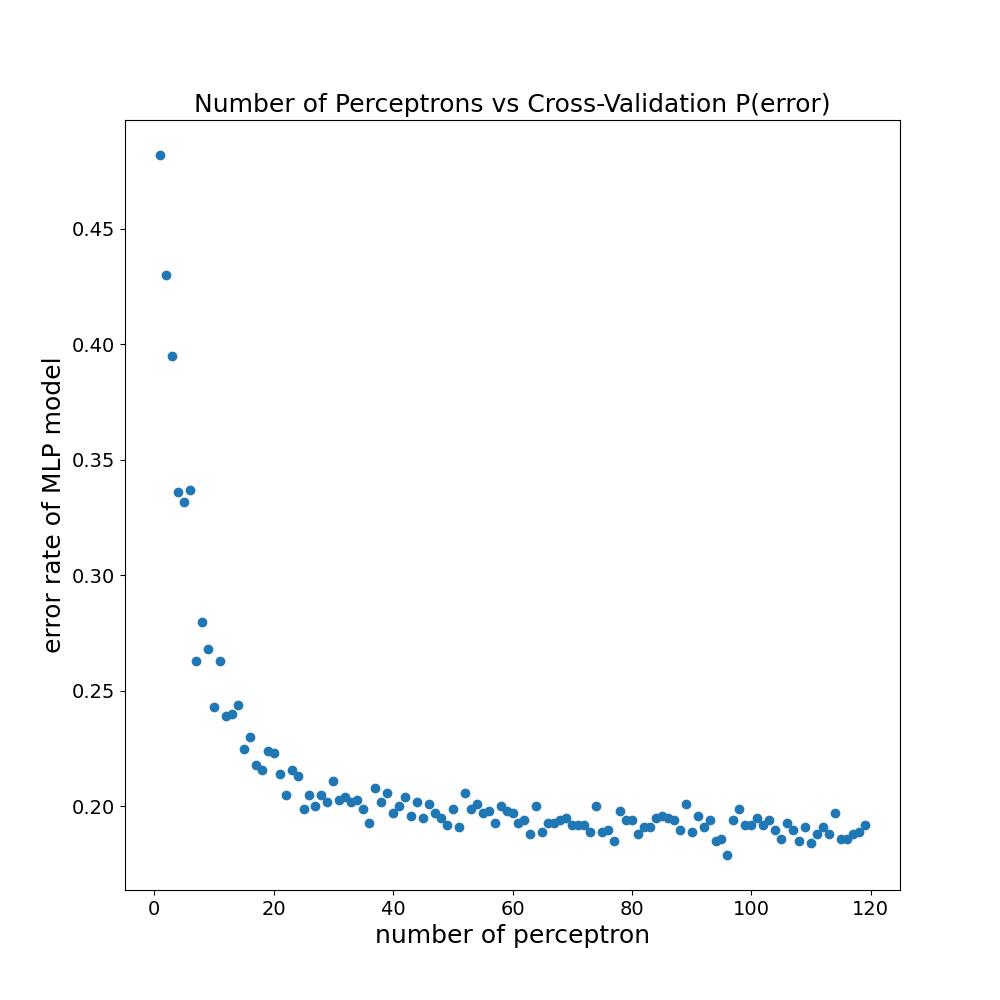

In [47]:
P_list = [2, 4, 8, 16, 24, 32, 48, 64, 128]
P_list = range(1, 120)

# Converting -1/+1 labels into a binary format, suitable for the MLP loss function
lb = LabelBinarizer()
y_train_binary = lb.fit_transform(y_train)[:, 0]

P_best = k_fold_cv_perceptrons(K, P_list, X_train, y_train_binary)

In [39]:
# Number of times to re-train same model with random re-initializations
num_restarts = 10

# Convert numpy structures to PyTorch tensors, necessary data types
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train_binary)

# List of trained MlPs for later testing
restart_mlps = []
restart_losses = []
# Remove chances of falling into suboptimal local minima
for r in range(num_restarts):
    model = TwoLayerMLP(X_train.shape[1], P_best)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    # Trained model
    model, loss = model_train(model, X_train_tensor, y_train_tensor, optimizer)
    restart_mlps.append(model)
    restart_losses.append(loss.detach().item())

# Choose best model from multiple restarts to list
best_mlp = restart_mlps[np.argmin(restart_losses)]

MLP Pr(error) on the test data set: 0.1742



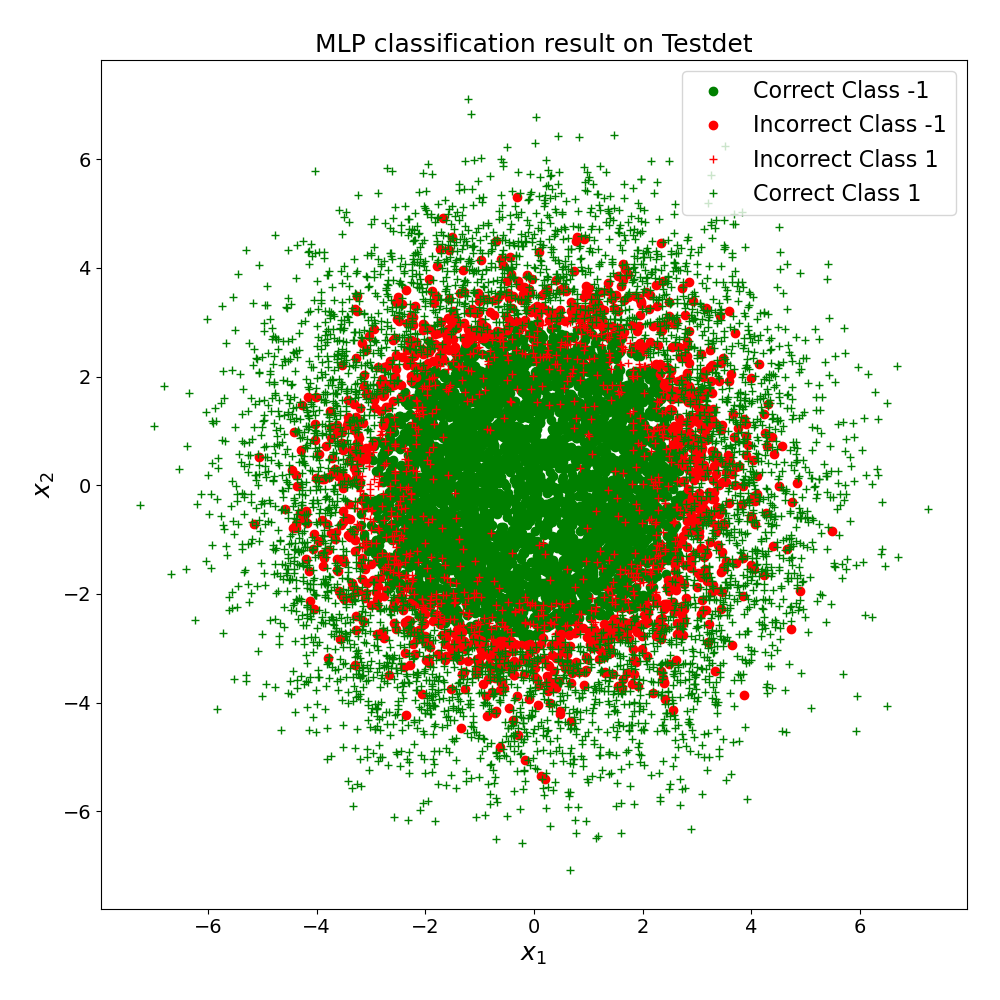

Confusion Matrix (rows: Predicted class, columns: True class):


Text(0.5, 0, 'Labels')

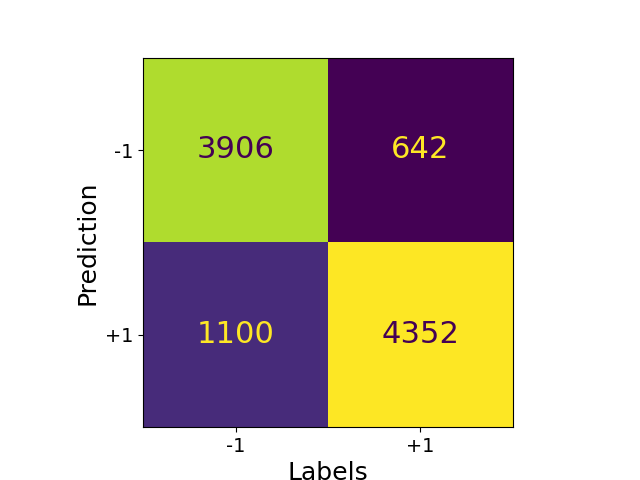

In [42]:
X_test_tensor = torch.FloatTensor(X_test)

# Evaluate the neural network on the test set
prediction_probs = model_predict(best_mlp, X_test_tensor)
# Decision boundary set to 0.5, hence rounding up sigmoid outputs
predictions = np.round(prediction_probs)
# Return back to original encoding
predictions = lb.inverse_transform(predictions)

# Get indices of correct and incorrect labels
incorrect_ind = np.argwhere(y_test != predictions)
prob_error_test = len(incorrect_ind) / N_test
print("MLP Pr(error) on the test data set: %.4f\n" % prob_error_test)

fig, ax = plt.subplots(figsize=(10, 10));

plot_binary_classification_results(ax, predictions, y_test)

grid_tensor = torch.FloatTensor(grid)
# Make predictions across region of interest from before when plotting the SVM decision surfaces
best_mlp.eval()
Z = best_mlp(grid_tensor).detach().numpy()
Z = lb.inverse_transform(np.round(Z)).reshape(xx.shape)
# ax.contourf(xx, yy, Z, cmap=plt.cm.viridis, alpha=0.25)

ax.set_xlabel(r"$x_1$");
ax.set_ylabel(r"$x_2$");
ax.set_title("MLP classification result on Testdet")
plt.legend();
plt.tight_layout();
plt.show()

# Simply using sklearn confusion matrix
print("Confusion Matrix (rows: Predicted class, columns: True class):")
conf_mat = confusion_matrix(predictions, y_test)
conf_display = ConfusionMatrixDisplay.from_predictions(predictions, y_test, display_labels=['-1', '+1'], colorbar=False)
plt.ylabel("Prediction")
plt.xlabel("Labels")